In [297]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score



In [298]:
lfw_people = fetch_lfw_people(min_faces_per_person=10,resize=0.4)
#选取样本量量更多的那些人脸，这样会方便训练
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [299]:
lfw_data = pd.DataFrame( lfw_people.data)	
lfw_data['species'] = lfw_people.target_names[lfw_people.target]	
lfw_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1841,1842,1843,1844,1845,1846,1847,1848,1849,species
0,0.358170,0.309804,0.487582,0.701961,0.801307,0.826144,0.856209,0.882353,0.903268,0.911111,...,0.202614,0.137255,0.129412,0.122876,0.138562,0.139869,0.129412,0.149020,0.156863,Jacques Chirac
1,0.231373,0.413072,0.633987,0.789542,0.886275,0.903268,0.900654,0.896732,0.891503,0.896732,...,0.054902,0.009150,0.019608,0.014379,0.003922,0.000000,0.000000,0.013072,0.020915,Abdullah Gul
2,0.341176,0.330719,0.383007,0.420915,0.450980,0.450980,0.443137,0.427451,0.452288,0.469281,...,0.194771,0.261438,0.294118,0.504575,0.555556,0.554248,0.464052,0.441830,0.503268,Serena Williams


In [300]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 4324
n_features: 1850
n_classes: 158


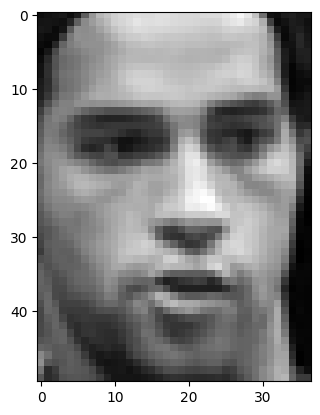

In [301]:
plt.imshow(lfw_people.images[5],cmap='gray')
plt.show()

# Preprocessing:


由于lfw数据集本身已经做了一些数据处理，比如每张图片的尺寸为250X250（shape统一），同时我们调用的数据集也做了灰度化处理来降低复杂度。因此数据预处理上可以做的事情就比较简单，我们可以比较两种数据预处理方法：标准化和归一化。（**可以分别在SVM、CNN上把两种预处理的数据都跑一遍看看结果符不符合预期**）

***标准化*** 

$$X=\frac{X-\mu}{\sigma}$$

作用：使数据均值为 0，方差为 1，适合基于距离的算法（如 SVM、KNN、PCA）。

但代码结果显示mean $\neq$ 0, $std \neq 1$,原因是PCA、SVM等机器学习模型都遵循scikit-learn 的约定，输入数据 X 必须是形状为 (n_samples, n_features) 的 二维数组，*每一行*是一个样本，*每一列*是一个特征值（如人脸图像的一个像素、一个颜色通道等），而实际代码计算的时候是根据特征值进行标准化（按列），即对于每个元素 $X_{ij}$:
$$ X_{ij}=\frac{X_{ij}-\mu_{j}}{\sigma_{j}} $$
而这里的mean和std都是按行（也就是对于一张图片而言）的，所以会存在mean不等于0等现象。

*标准化的特点*:标准化计算中

$$\mu = \frac{1}{n}\sum_{i=1}^n X, \quad \sigma = \sqrt{\frac{1}{n}\sum_{i=1}^n (X-\mu)^2} $$

经过标准化后，对于标准差 $\sigma$ 较大的特征值，由于标准差计算中 $\sigma$ 在分母，会实际缩小这些值的差异，让不同图片中区分度很大的地方（可能是噪声）变平滑；同时，对于标准差 $\sigma$ 较小的特征值，标准差计算会放大这些值的特点，也就是对于图像中相同的或者相似的部分，标准化会增强这一特征（比如图片亮处更亮、暗处更暗）。所以整体上，标准化可以使同一特征值的数据更加一致，数据间的距离和差值更小，因此适合基于距离的算法（如 SVM、KNN、PCA）。

***归一化*** 

$$X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

作用：将数据线性压缩到固定范围（默认 [0, 1]），适合需要限定输入范围的模型（如神经网络）。

*归一化的特点*：归一化计算中实际上也是对特征进行计算：
$$X_{norm}[:,j] = \frac{X[:,j]-minX[:,j]}{maxX[:,j]-minX[:,j]}$$
这本质上是一种线性变换，数据的分布形状不会产生变化，仅仅是进行缩放和平移（仿射变换），也解释了跑出来的图相较和原图差异不大的现象。
$$X_{norm}=aX+b,\quad a=\frac{1}{X_{max}-X_{min}},\quad b=\frac{-X_{min}}{X_{max}-X_{min}} $$

和Batch Normalization一样，缓解梯度消失/爆炸问题，适用于CNN


=== Sample 1453 (Person: Gray Davis) ===


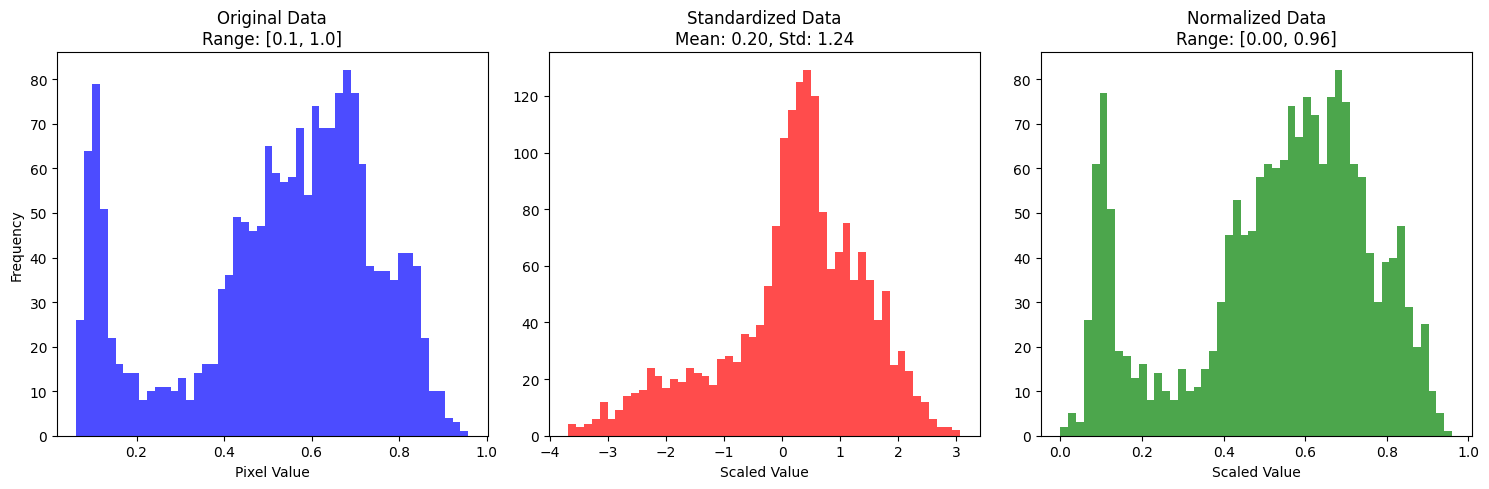

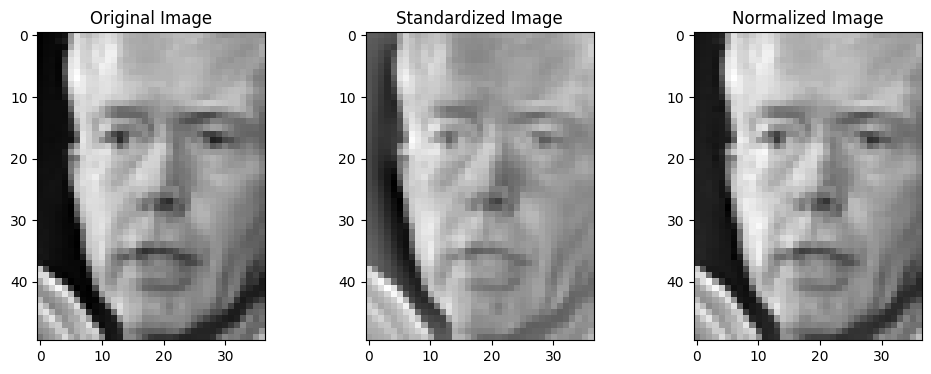


=== Sample 1027 (Person: Naomi Watts) ===


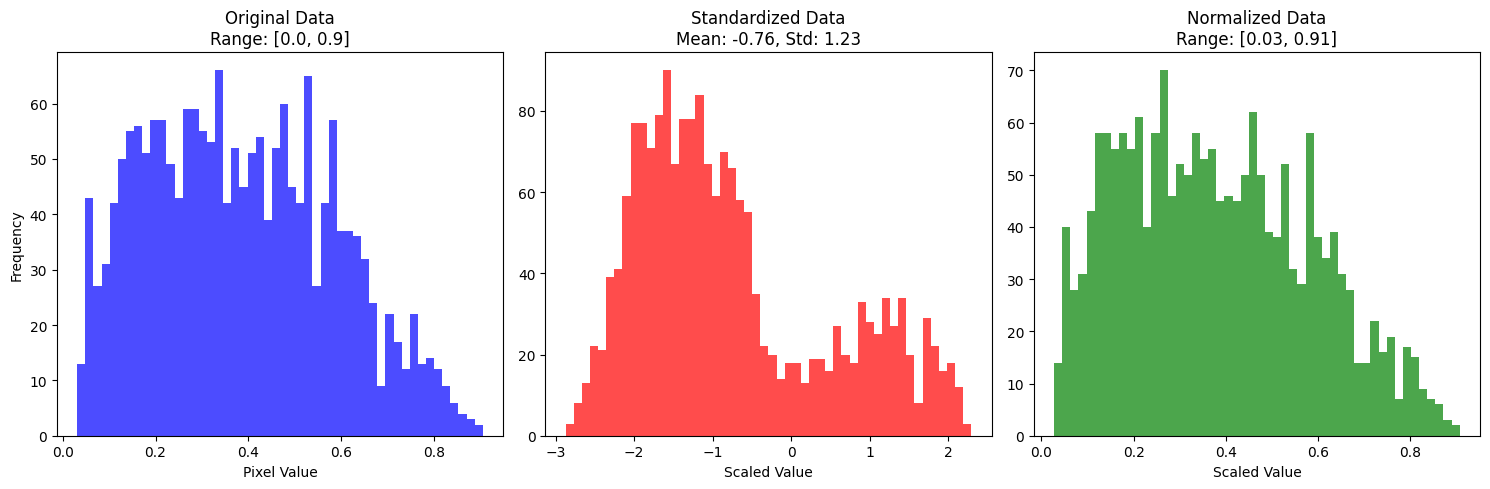

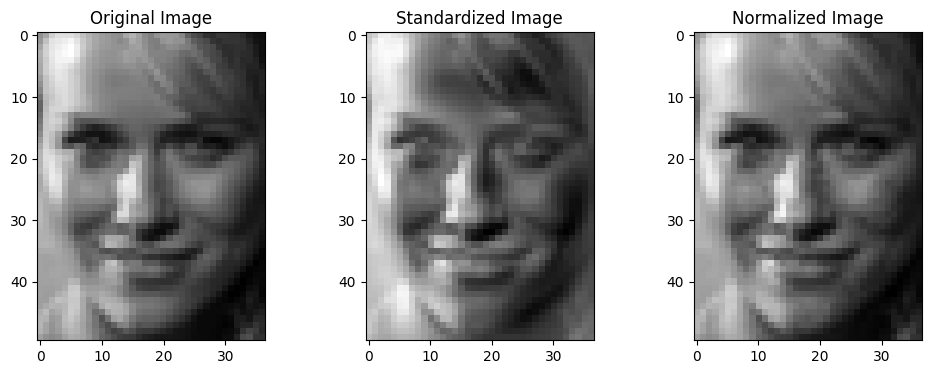


=== Sample 2921 (Person: George W Bush) ===


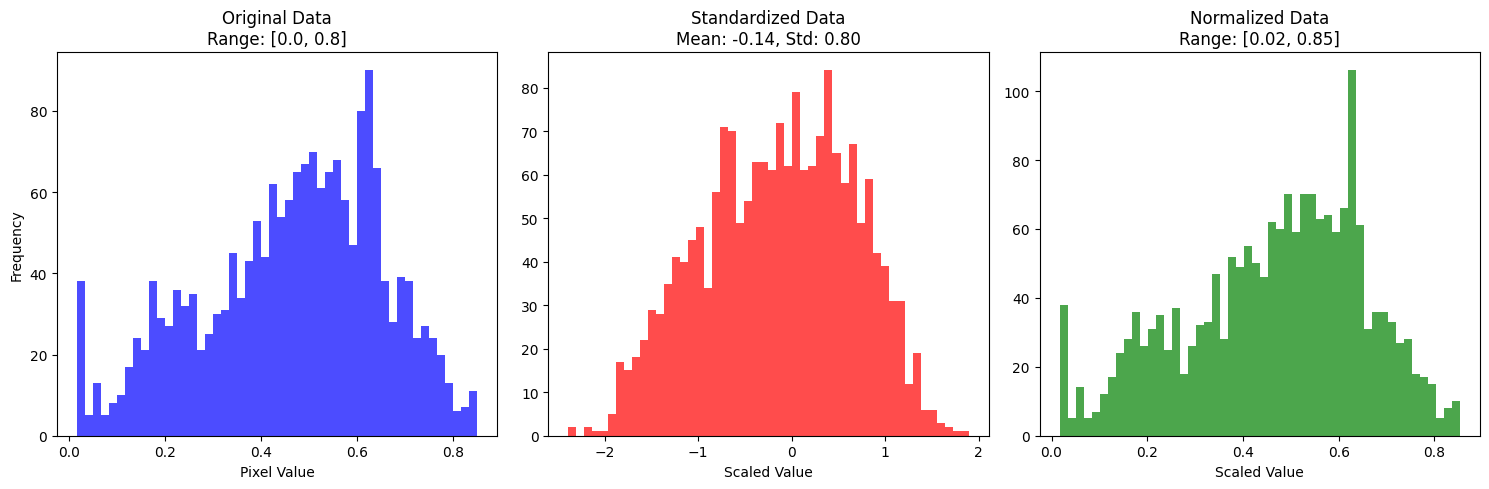

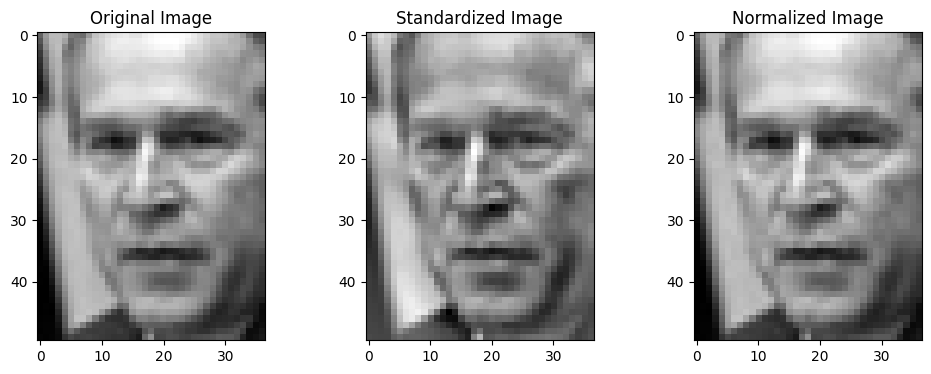


=== Sample 2295 (Person: Norah Jones) ===


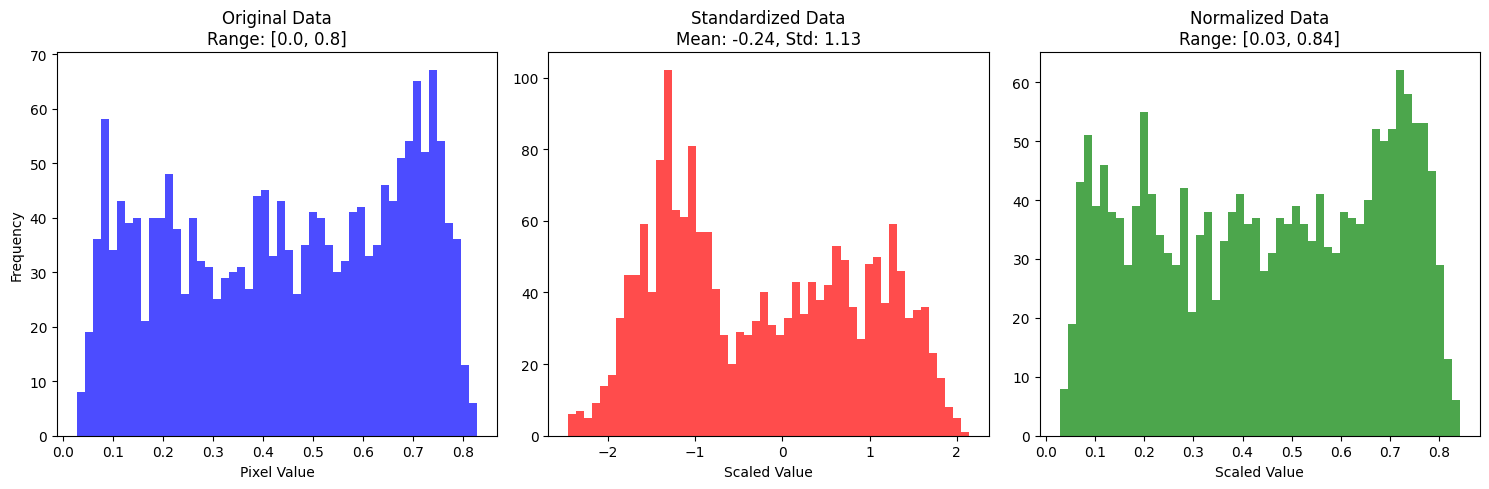

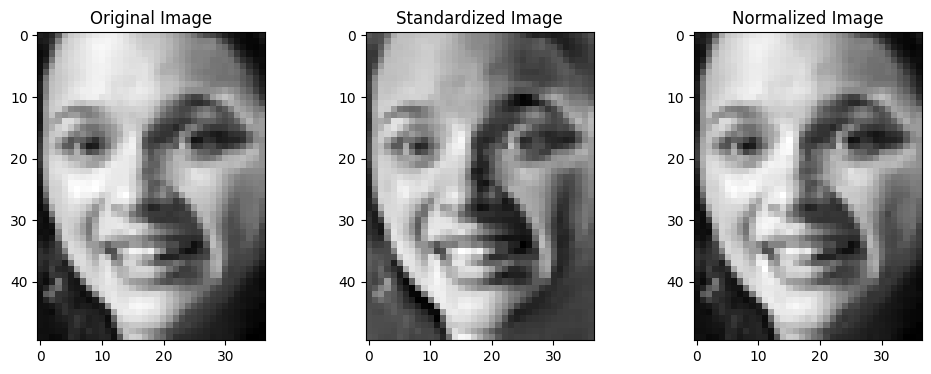


=== Sample 1306 (Person: Joschka Fischer) ===


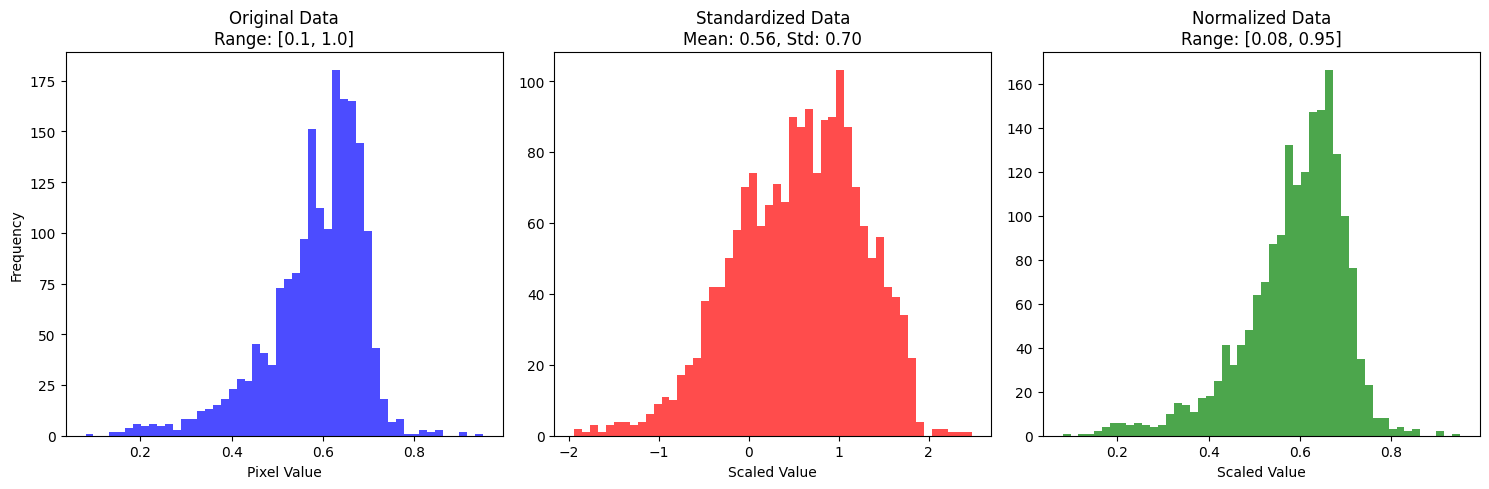

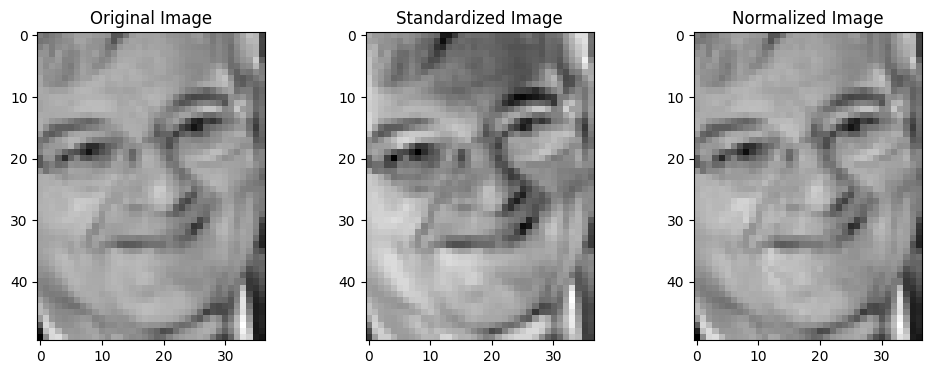

In [302]:
# 2. 预处理
# 标准化
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)
# 归一化
scaler_norm = MinMaxScaler()
X_norm = scaler_norm.fit_transform(X)

# 3. 可视化分布
def plot_distribution(X_original, X_std, X_norm, sample_idx=0):
    """绘制三种处理方式的分布对比"""
    plt.figure(figsize=(15, 5))
    
    # 原始数据
    plt.subplot(1, 3, 1)
    plt.hist(X_original[sample_idx], bins=50, color='blue', alpha=0.7)
    plt.title(f"Original Data\nRange: [{X_original[sample_idx].min():.1f}, {X_original[sample_idx].max():.1f}]")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    
    # 标准化后
    plt.subplot(1, 3, 2)
    plt.hist(X_std[sample_idx], bins=50, color='red', alpha=0.7)
    plt.title(f"Standardized Data\nMean: {X_std[sample_idx].mean():.2f}, Std: {X_std[sample_idx].std():.2f}")
    plt.xlabel("Scaled Value")
    
    # 归一化后
    plt.subplot(1, 3, 3)
    plt.hist(X_norm[sample_idx], bins=50, color='green', alpha=0.7)
    plt.title(f"Normalized Data\nRange: [{X_norm[sample_idx].min():.2f}, {X_norm[sample_idx].max():.2f}]")
    plt.xlabel("Scaled Value")
    
    plt.tight_layout()
    plt.show()

# 4. 随机选择5个人脸样本对比
for i in np.random.choice(len(X), 5, replace=False):
    print(f"\n=== Sample {i} (Person: {lfw_people.target_names[lfw_people.target[i]]}) ===")
    plot_distribution(X, X_std, X_norm, sample_idx=i)
    
    # 可视化图像对比
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X[i].reshape(h, w), cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(X_std[i].reshape(h, w), cmap='gray')
    axes[1].set_title("Standardized Image")
    axes[2].imshow(X_norm[i].reshape(h, w), cmap='gray')
    axes[2].set_title("Normalized Image")
    plt.show()

In [303]:

class_counts = Counter(lfw_people.target)

print("类别分布:", class_counts)

类别分布: Counter({np.int64(35): 530, np.int64(23): 236, np.int64(149): 144, np.int64(29): 121, np.int64(36): 109, np.int64(11): 77, np.int64(49): 71, np.int64(85): 60, np.int64(61): 55, np.int64(73): 53, np.int64(54): 52, np.int64(134): 52, np.int64(153): 49, np.int64(95): 48, np.int64(37): 44, np.int64(65): 42, np.int64(12): 42, np.int64(91): 41, np.int64(93): 41, np.int64(44): 39, np.int64(2): 39, np.int64(110): 37, np.int64(5): 36, np.int64(3): 35, np.int64(137): 33, np.int64(99): 33, np.int64(146): 33, np.int64(152): 32, np.int64(89): 32, np.int64(129): 32, np.int64(77): 31, np.int64(25): 31, np.int64(122): 30, np.int64(41): 30, np.int64(14): 29, np.int64(97): 29, np.int64(52): 28, np.int64(82): 28, np.int64(124): 27, np.int64(131): 26, np.int64(40): 26, np.int64(144): 25, np.int64(13): 24, np.int64(156): 24, np.int64(68): 24, np.int64(81): 23, np.int64(141): 23, np.int64(132): 23, np.int64(92): 22, np.int64(34): 22, np.int64(119): 22, np.int64(43): 22, np.int64(109): 22, np.int64(4):

样本量在10-50之间的类别及数量:
类别 Abdullah Gul: 19 个样本
类别 Vladimir Putin: 49 个样本
类别 James Blake: 14 个样本
类别 Silvio Berlusconi: 33 个样本
类别 Yoriko Kawaguchi: 14 个样本
类别 Mohammed Al-Douri: 15 个样本
类别 Bill Simon: 15 个样本
类别 Gloria Macapagal Arroyo: 44 个样本
类别 Dominique de Villepin: 15 个样本
类别 John Kerry: 17 个样本
类别 Lindsay Davenport: 22 个样本
类别 Alvaro Uribe: 35 个样本
类别 Catherine Zeta-Jones: 11 个样本
类别 Andy Roddick: 15 个样本
类别 Jose Maria Aznar: 23 个样本
类别 James Kelly: 11 个样本
类别 Atal Bihari Vajpayee: 24 个样本
类别 Winona Ryder: 24 个样本
类别 Roger Federer: 14 个样本
类别 Paul Wolfowitz: 10 个样本
类别 Rudolph Giuliani: 26 个样本
类别 Richard Gephardt: 11 个样本
类别 Laura Bush: 41 个样本
类别 Javier Solana: 10 个样本
类别 Keanu Reeves: 12 个样本
类别 David Nalbandian: 14 个样本
类别 George Robertson: 22 个样本
类别 Jennifer Capriati: 42 个样本
类别 Kim Ryong-sung: 11 个样本
类别 John Negroponte: 31 个样本
类别 Spencer Abraham: 17 个样本
类别 Ricardo Lagos: 27 个样本
类别 Jeb Bush: 12 个样本
类别 Vicente Fox: 32 个样本
类别 Jiri Novak: 11 个样本
类别 Luiz Inacio Lula da Silva: 48 个样本
类别 Andre Agassi: 36 个样本


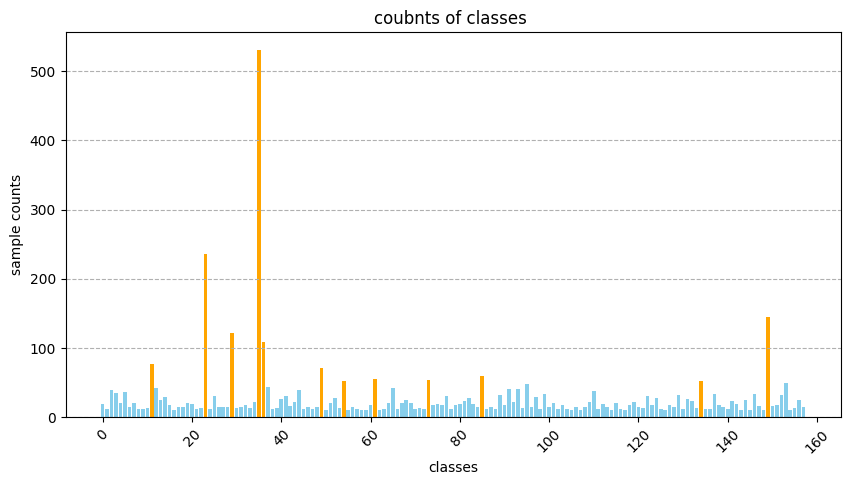

In [304]:
rare_classes = {cls: count for cls, count in class_counts.items() if 10 <= count <= 50}
ma_classes = {cls: count for cls, count in class_counts.items() if count > 50}
print(f"样本量在10-50之间的类别及数量:")
for cls, count in rare_classes.items():
    print(f"类别 {target_names[cls]}: {count} 个样本")
print("样本量大于50的类别及数量:")
for cls, count in ma_classes.items():
    print(f"类别 {target_names[cls]}: {count} 个样本")


# 提取类别和样本数
rclasses = list(rare_classes.keys())
rcounts = list(rare_classes.values())
mclasses= list(ma_classes.keys())
mcounts = list(ma_classes.values())

# 绘制条形图
plt.figure(figsize=(10, 5))
plt.bar(rclasses, rcounts, color='skyblue')
plt.bar(mclasses, mcounts, color='orange')

plt.xlabel("classes")
plt.ylabel("sample counts")
plt.title("coubnts of classes ")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

In [305]:
X_rare,y_rare,X_rare_train,y_rare_train,X_rare_test,y_rare_test = [],[],[],[],[],[]
X_ma,y_ma,X_ma_train,y_ma_train,X_ma_test,y_ma_test = [],[],[],[],[],[]
#rare_classes = {cls: count for cls, count in class_counts.items() if 10 <= count <= 30}
for cls in rclasses:
    cls_id=np.where(lfw_people.target==cls)[0]
    X_rare.append(lfw_people.data[cls_id])
    y_rare.append(lfw_people.target[cls_id])

X_rare = np.concatenate(X_rare)
y_rare = np.concatenate(y_rare)
X_rare_train, X_rare_test, y_rare_train, y_rare_test = train_test_split(X_rare, y_rare, test_size=0.25)
#ma_classes = {cls: count for cls, count in class_counts.items() if count > 30}
for cls in mclasses:
    cls_id=np.where(lfw_people.target==cls)[0]
    X_ma.append(lfw_people.data[cls_id])
    y_ma.append(lfw_people.target[cls_id])

X_ma = np.concatenate(X_ma)
y_ma = np.concatenate(y_ma)    
X_ma_train, X_ma_test, y_ma_train, y_ma_test = train_test_split(X_ma, y_ma, test_size=0.25)

print("Rare classes train and test sets:")
print("X_rare shape:", X_rare.shape)
print("y_rare shape:", y_rare.shape)
print("X_ma shape:", X_ma.shape)
print("y_ma shape:", y_ma.shape)
print("X_rare_train shape:", X_rare_train.shape)
print("Unique classes in y_rare_train:", len(np.unique(y_rare_train)))
print("X_ma_train shape:", X_ma_train.shape)
print("Unique classes in y_ma_train:", len(np.unique(y_ma_train)))
print("X_rare_test shape:", X_rare_test.shape)
print("Unique classes in y_rare_test:", len(np.unique(y_rare_test)))
print("X_ma_test shape:", X_ma_test.shape)
print("Unique classes in y_ma_test:", len(np.unique(y_ma_test)))
print("Length of target_names:", len(lfw_people.target_names))

Rare classes train and test sets:
X_rare shape: (2764, 1850)
y_rare shape: (2764,)
X_ma shape: (1560, 1850)
y_ma shape: (1560,)
X_rare_train shape: (2073, 1850)
Unique classes in y_rare_train: 146
X_ma_train shape: (1170, 1850)
Unique classes in y_ma_train: 12
X_rare_test shape: (691, 1850)
Unique classes in y_rare_test: 142
X_ma_test shape: (390, 1850)
Unique classes in y_ma_test: 12
Length of target_names: 158


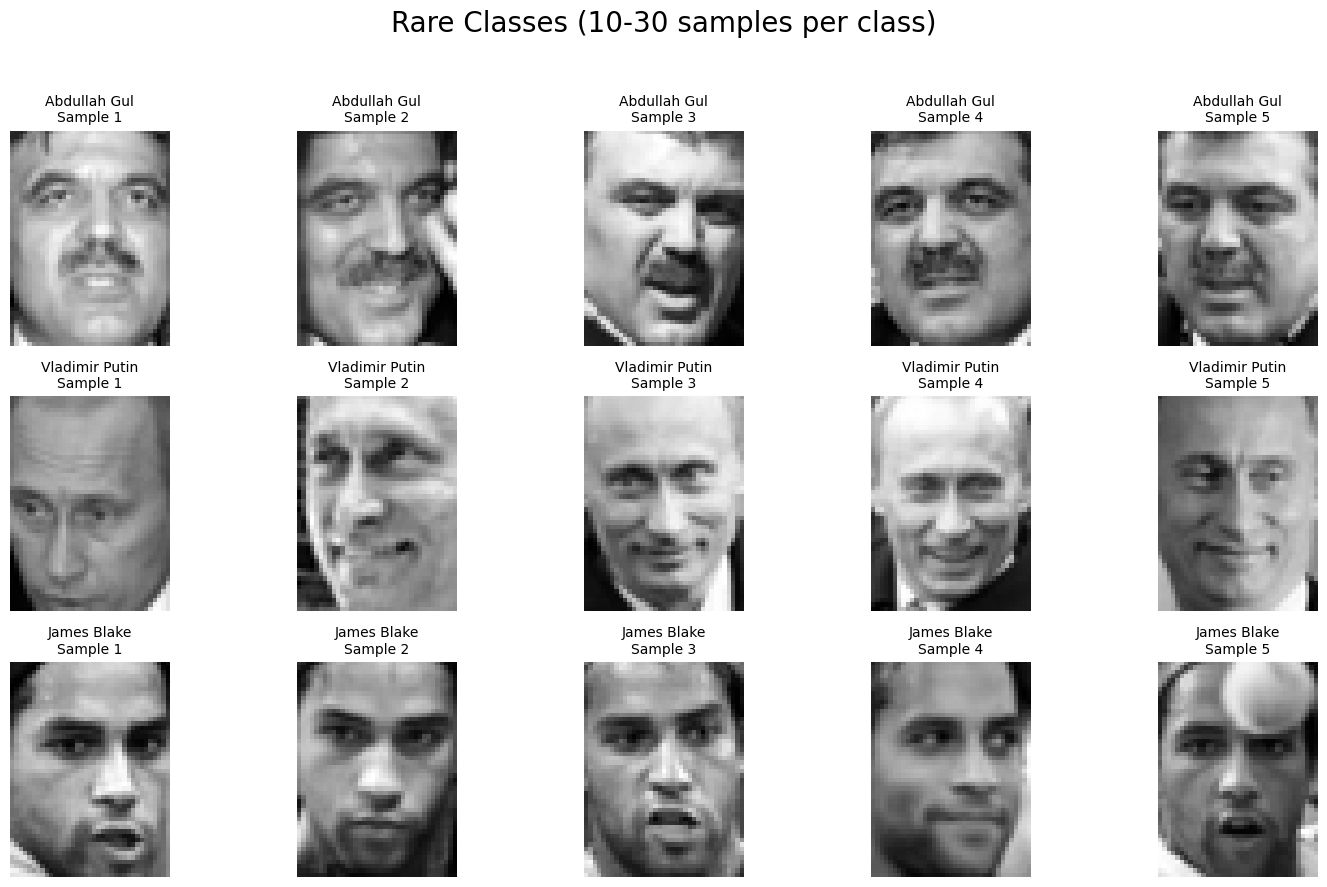

In [306]:


n_samples_to_show = 5  # 每个类别显示5张图片
max_classes_to_show = 3  # 最多显示3个稀有类别

# 获取要展示的类别
rare_class_items = list(rare_classes.items())[:max_classes_to_show]

# 设置画布尺寸：每行 5 张图，图像大一些
fig, axes = plt.subplots(len(rare_class_items), n_samples_to_show, figsize=(n_samples_to_show * 3, len(rare_class_items) * 3))
fig.suptitle("Rare Classes (10-30 samples per class)", fontsize=20)

for i, (cls, count) in enumerate(rare_class_items):
    cls_indices = np.where(y == cls)[0]
    selected_indices = np.random.choice(cls_indices, size=min(n_samples_to_show, len(cls_indices)), replace=False)
    
    for j in range(n_samples_to_show):
        ax = axes[i][j] if len(rare_class_items) > 1 else axes[j]  # 兼容1行的情况
        
        if j < len(selected_indices):
            idx = selected_indices[j]
            ax.imshow(lfw_people.images[idx], cmap='gray')
            ax.set_title(f"{target_names[cls]}\nSample {j+1}", fontsize=10)
        else:
            ax.axis('off')  # 没有足够样本时隐藏多余子图

        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出标题位置
plt.show()



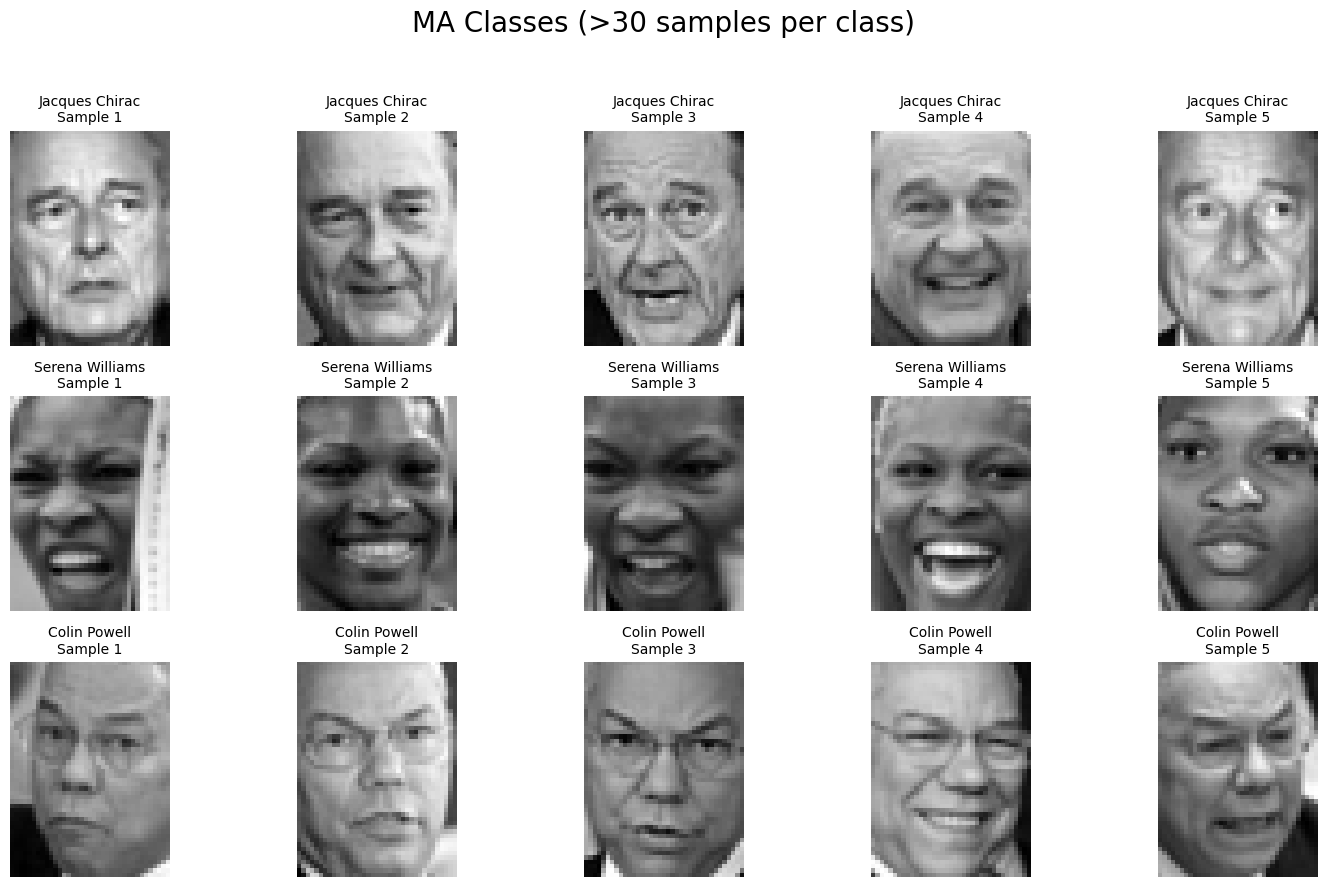

In [307]:

ma_class_items = list(ma_classes.items())[:max_classes_to_show]

# 创建子图：每行 5 张图像
fig, axes = plt.subplots(len(ma_class_items), n_samples_to_show, figsize=(n_samples_to_show * 3, len(ma_class_items) * 3))
fig.suptitle("MA Classes (>30 samples per class)", fontsize=20)

for i, (cls, count) in enumerate(ma_class_items):
    cls_indices = np.where(y == cls)[0]
    selected_indices = np.random.choice(cls_indices, size=min(n_samples_to_show, len(cls_indices)), replace=False)

    for j in range(n_samples_to_show):
        ax = axes[i][j] if len(ma_class_items) > 1 else axes[j]  # 兼容仅1行的情况

        if j < len(selected_indices):
            idx = selected_indices[j]
            ax.imshow(lfw_people.images[idx], cmap='gray')
            ax.set_title(f"{target_names[cls]}\nSample {j+1}", fontsize=10)
        else:
            ax.axis('off')  # 不足5张样本时隐藏多余子图

        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 留出标题位置
plt.show()


In [308]:
from sklearn.preprocessing import StandardScaler
#标准化操作
scaler = StandardScaler()
X_rare_train = scaler.fit_transform(X_rare_train)
X_rare_test = scaler.transform(X_rare_test)
X_ma_train = scaler.fit_transform(X_ma_train)
X_ma_test = scaler.transform(X_ma_test)

## Using SVC only

In [309]:
model = SVC(kernel='rbf',class_weight='balanced')
model.fit(X_rare_train,y_rare_train)

SVC(class_weight='balanced')

In [310]:
predictions=model.predict(X_rare_test)

labels_in_use = np.unique(np.concatenate([y_rare_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]

# 打印分类报告
print(classification_report(y_rare_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))


                           precision    recall  f1-score   support

             Abdullah Gul       0.75      0.43      0.55         7
             Adrien Brody       0.00      0.00      0.00         1
         Alejandro Toledo       0.11      0.14      0.12         7
             Alvaro Uribe       0.08      0.11      0.10         9
          Amelie Mauresmo       0.33      0.67      0.44         3
             Andre Agassi       0.29      0.50      0.37        10
             Andy Roddick       0.00      0.00      0.00         5
           Angelina Jolie       0.25      0.17      0.20         6
              Ann Veneman       0.00      0.00      0.00         0
          Anna Kournikova       0.00      0.00      0.00         0
            Ari Fleischer       0.67      1.00      0.80         2
    Arnold Schwarzenegger       0.05      0.08      0.06        12
     Atal Bihari Vajpayee       0.00      0.00      0.00         1
             Bill Clinton       0.00      0.00      0.00     

In [311]:
model = SVC(kernel='rbf',class_weight='balanced')
model.fit(X_ma_train,y_ma_train)
predictions=model.predict(X_ma_test)

labels_in_use = np.unique(np.concatenate([y_ma_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]

# 打印分类报告
print(classification_report(y_ma_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))

                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.90      0.75        10
     Colin Powell       0.70      0.80      0.74        60
  Donald Rumsfeld       0.65      0.71      0.68        28
    George W Bush       0.87      0.81      0.84       138
Gerhard Schroeder       0.62      0.56      0.59        27
      Hugo Chavez       0.60      0.47      0.53        19
   Jacques Chirac       0.57      0.31      0.40        13
    Jean Chretien       0.75      0.60      0.67        10
    John Ashcroft       0.68      0.72      0.70        18
Junichiro Koizumi       0.94      0.89      0.91        18
  Serena Williams       0.70      0.88      0.78        16
       Tony Blair       0.65      0.73      0.69        33

         accuracy                           0.74       390
        macro avg       0.70      0.70      0.69       390
     weighted avg       0.75      0.74      0.74       390



# PCA
- 选择过少的主成分可能导致严重的信息丢失，影响后续分析或模型性能。
- 选择过多的主成分则可能削弱降维带来的计算效率提升和噪声过滤优势。

因此，在实际操作中需要平衡降维效果与信息保留的关系。
## 累计方差贡献率法

用于决定主成分个数。具体步骤如下：

1. 计算每个主成分的方差贡献率。
2. 累加前几个主成分的方差贡献率，直到其达到或超过85、86、87..99%
3. 选择让acc最大化的对应的主成分个数作为最终结果。



In [312]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

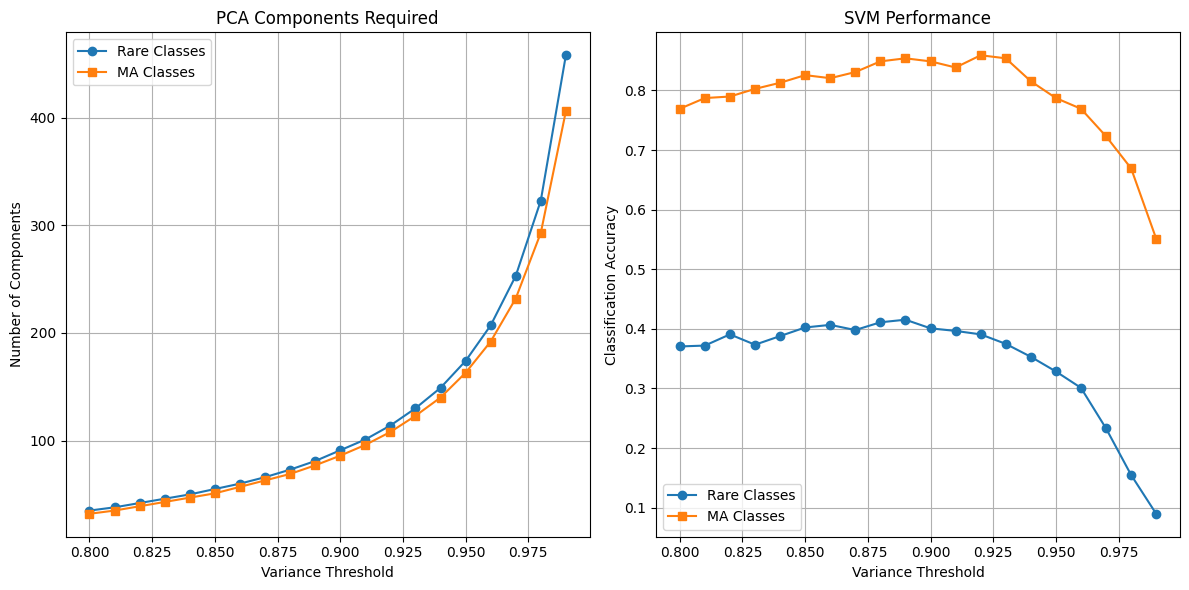

Rare Classes Results:
Threshold 0.80: 35 components, Accuracy=0.3705
Threshold 0.81: 38 components, Accuracy=0.3719
Threshold 0.82: 42 components, Accuracy=0.3907
Threshold 0.83: 46 components, Accuracy=0.3734
Threshold 0.84: 50 components, Accuracy=0.3878
Threshold 0.85: 55 components, Accuracy=0.4023
Threshold 0.86: 60 components, Accuracy=0.4067
Threshold 0.87: 66 components, Accuracy=0.3980
Threshold 0.88: 73 components, Accuracy=0.4110
Threshold 0.89: 81 components, Accuracy=0.4153
Threshold 0.90: 91 components, Accuracy=0.4009
Threshold 0.91: 101 components, Accuracy=0.3965
Threshold 0.92: 114 components, Accuracy=0.3907
Threshold 0.93: 130 components, Accuracy=0.3748
Threshold 0.94: 149 components, Accuracy=0.3531
Threshold 0.95: 174 components, Accuracy=0.3285
Threshold 0.96: 207 components, Accuracy=0.3010
Threshold 0.97: 253 components, Accuracy=0.2330
Threshold 0.98: 323 components, Accuracy=0.1548
Threshold 0.99: 458 components, Accuracy=0.0897

MA Classes Results:
Threshol

In [318]:


# 设置方差阈值列表和存储结果的字典
variance_thresholds = np.linspace(0.8, 0.99, 20)
results = {
    'rare': {'n_components': [], 'accuracy': []},
    'ma': {'n_components': [], 'accuracy': []}
}

# 定义评估函数
def evaluate_pca_svm(X_train, X_test, y_train, y_test, dataset_type):
    pca_full = PCA().fit(X_train)
    cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
    
    for threshold in variance_thresholds:
        # 计算所需主成分数
        n_components = np.argmax(cumulative_var >= threshold) + 1
        results[dataset_type]['n_components'].append(n_components)
        
        # PCA降维
        pca = PCA(n_components=n_components, whiten=True)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # 训练SVM并评估
        model = SVC(kernel='rbf', class_weight='balanced')
        model.fit(X_train_pca, y_train)
        pred = model.predict(X_test_pca)
        acc = accuracy_score(y_test, pred)
        results[dataset_type]['accuracy'].append(acc)

# 对rare和ma数据集分别评估
evaluate_pca_svm(X_rare_train, X_rare_test, y_rare_train, y_rare_test, 'rare')
evaluate_pca_svm(X_ma_train, X_ma_test, y_ma_train, y_ma_test, 'ma')

# 可视化结果
plt.figure(figsize=(12, 6))

# 主成分数量对比
plt.subplot(1, 2, 1)
plt.plot(variance_thresholds, results['rare']['n_components'], 'o-', label='Rare Classes')
plt.plot(variance_thresholds, results['ma']['n_components'], 's-', label='MA Classes')
plt.xlabel('Variance Threshold')
plt.ylabel('Number of Components')
plt.title('PCA Components Required')
plt.legend()
plt.grid(True)

# 分类准确度对比
plt.subplot(1, 2, 2)
plt.plot(variance_thresholds, results['rare']['accuracy'], 'o-', label='Rare Classes')
plt.plot(variance_thresholds, results['ma']['accuracy'], 's-', label='MA Classes')
plt.xlabel('Variance Threshold')
plt.ylabel('Classification Accuracy')
plt.title('SVM Performance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印详细结果
print("Rare Classes Results:")
for i, thresh in enumerate(variance_thresholds):
    print(f"Threshold {thresh:.2f}: {results['rare']['n_components'][i]} components, Accuracy={results['rare']['accuracy'][i]:.4f}")

print("\nMA Classes Results:")
for i, thresh in enumerate(variance_thresholds):
    print(f"Threshold {thresh:.2f}: {results['ma']['n_components'][i]} components, Accuracy={results['ma']['accuracy'][i]:.4f}")

print(f"Max accuracy for rare classes:{ max(results['rare']['accuracy'])},n_components:{results['rare']['n_components'][np.argmax(results['rare']['accuracy'])]}")
print("Max accuracy for ma classes:", max(results['ma']['accuracy']))
print(f"Max accuracy for ma classes:{ max(results['ma']['accuracy'])},n_components:{results['ma']['n_components'][np.argmax(results['ma']['accuracy'])]}")

rare和ma的准确率变化趋势其实差不多，但是到达峰值所需要的主成分数ma总是大于rare。

在调节主成分数时，Rare（稀有类别）和MA（普通类别）的准确率变化趋势相似但峰值所需主成分数不同，这一现象可以从数据特性和PCA的数学本质来解释。

### **1. 数据复杂度差异**

#### **(1) 稀有类别（Rare）的特性**

- **样本量少**：每个稀有类别的样本数较少（10-30个），导致：
  - 数据分布估计不准确，PCA捕获的方差结构可能不稳定
  - 更易达到"信息饱和"（少量主成分即可捕获主要模式）
- **特征简单性**：稀有类别的样本可能具有更简单的共同特征（如相似光照/角度）

#### **(2) 普通类别（MA）的特性**

- **样本量大**：每个类别样本更多（>30个），导致：
  - 类内多样性更高（不同姿态、表情等）
  - 需要更多主成分才能覆盖这些复杂变化
- **类别间重叠**：普通类别间可能存在更多特征重叠，需要更高维度的判别信息

Rare classes accuracy: 0.4182344428364689
Final Accuracy with 81 components: 0.4182
parameters of svc: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
                           precision    recall  f1-score   support

             Abdullah Gul       1.00      0.43      0.60         7
             Adrien Brody       0.00      0.00      0.00         1
         Alejandro Toledo       0.36      0.57      0.44         7
             Alvaro Uribe       0.46      0.67      0.55         9
          Amelie Mauresmo       0.50      0.67      0.57         3
             Andre Agassi       0.17      0.40      0.24        10
             Andy Roddick       0.00      0.00      0.00         5
           Angelina Jolie       0.33      0.33      0.33         6
       

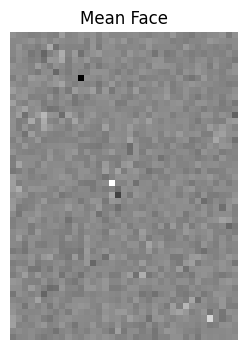

In [319]:
from sklearn.preprocessing import StandardScaler

n_components=81
pca=PCA(n_components=n_components,whiten=True).fit(X_rare_train)
#x_all_pca=pca.transform(lfw_people.data)
X_rare_train_pca=pca.fit_transform(X_rare_train)
X_rare_test_pca=pca.transform(X_rare_test)
model = SVC(kernel='rbf', class_weight='balanced')
model.fit(X_rare_train_pca, y_rare_train)
pred = model.predict(X_rare_test_pca)
acc = accuracy_score(y_rare_test, pred)
# 打印分类报告
print("Rare classes accuracy:", acc)
print(f"Final Accuracy with {n_components} components: {acc:.4f}")
print("parameters of svc:",model.get_params())
labels_in_use = np.unique(np.concatenate([y_rare_test, pred]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]
print(classification_report(y_rare_test, pred,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))
mean_face = pca.mean_.reshape((h, w))
plt.figure(figsize=(4, 4))
plt.imshow(mean_face, cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

eigenfaces_rare = pca.components_.reshape((81, h, w))




mean 图像非常抽象，没有特征的表达。学到的特征比较简单，也就导致最后得到的较优主成分数比较少

                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.90      0.86        10
     Colin Powell       0.65      1.00      0.79        60
  Donald Rumsfeld       0.85      0.82      0.84        28
    George W Bush       0.94      0.92      0.93       138
Gerhard Schroeder       0.88      0.81      0.85        27
      Hugo Chavez       0.93      0.68      0.79        19
   Jacques Chirac       1.00      0.62      0.76        13
    Jean Chretien       1.00      0.80      0.89        10
    John Ashcroft       0.93      0.78      0.85        18
Junichiro Koizumi       1.00      0.72      0.84        18
  Serena Williams       0.91      0.62      0.74        16
       Tony Blair       0.84      0.79      0.81        33

         accuracy                           0.85       390
        macro avg       0.90      0.79      0.83       390
     weighted avg       0.88      0.85      0.85       390

MA classes accuracy: 0.8538461538461538
Final Accurac

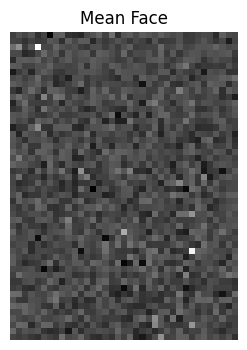

In [320]:

pca = PCA(n_components=108, whiten=True)
X_ma_train_pca = pca.fit_transform(X_ma_train)
X_ma_test_pca = pca.transform(X_ma_test)

# 训练SVM并评估
model = SVC(kernel='rbf', class_weight='balanced')
model.fit(X_ma_train_pca, y_ma_train)
pred = model.predict(X_ma_test_pca)
acc = accuracy_score(y_ma_test, pred)
# 打印分类报告
labels_in_use = np.unique(np.concatenate([y_ma_test, pred]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]
print(classification_report(y_ma_test, pred,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))
print("MA classes accuracy:", acc)
print(f"Final Accuracy with n components: {acc:.4f}")
print("parameter of SVC:",model.get_params())

eigenfaces_ma = pca.components_.reshape((108, h, w))
mean_face = pca.mean_.reshape((h, w))
plt.figure(figsize=(4, 4))
plt.imshow(mean_face, cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()
from sklearn.metrics.pairwise import euclidean_distances

# 找出距离平均脸最近的训练图像
mean_vector = pca.mean_.reshape(1, -1)         # shape (1, D)
dists = euclidean_distances(X_ma_train, mean_vector).flatten()
closest_idx = np.argmin(dists)





mean图像上有更加突出的形状，说明样本量多的话学到的特征也会多。

Rare classes eigenfaces:
MA classes eigenfaces:


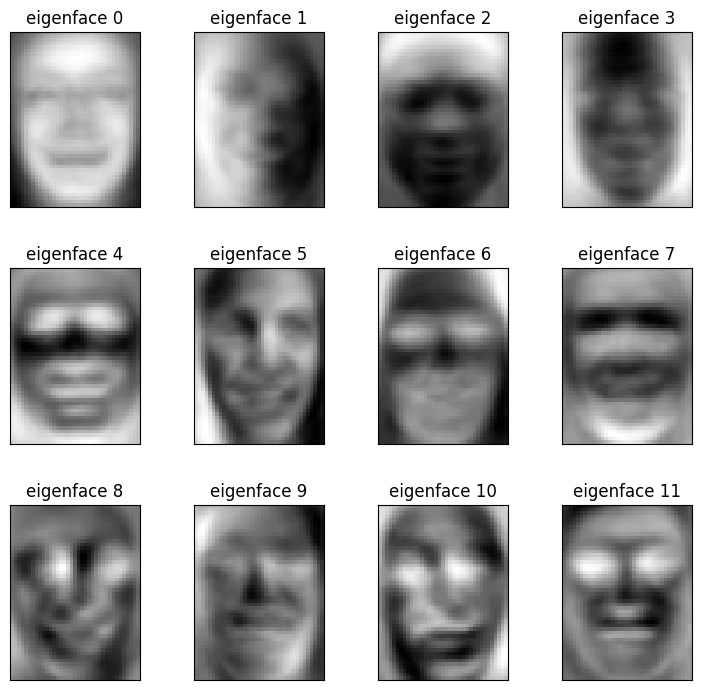

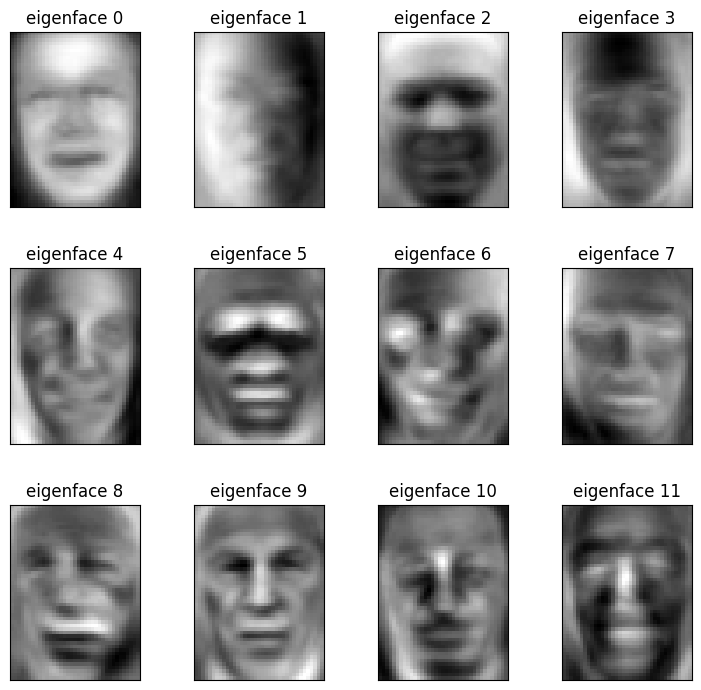

In [321]:


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_rare.shape[0])]
plot_gallery(eigenfaces_rare, eigenface_titles, h, w)
print("Rare classes eigenfaces:")
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_ma.shape[0])]
plot_gallery(eigenfaces_ma, eigenface_titles, h, w)
print("MA classes eigenfaces:")
plt.show()

# diff_pc = np.argmax(np.sum(np.abs(eigenfaces_rare - eigenfaces_ma), axis=(1, 2)))
# plt.imshow(eigenfaces_rare[diff_pc] - eigenfaces_ma[diff_pc], cmap='seismic')
# plt.colorbar()
# plt.title(f'diff max(PC{diff_pc+1})')
# plt.show()

从特征脸上也能看出问题：一方面maclass学到了更多特征另一方面学到的特征更具体。

## 调参 我尽力了

In [333]:
from scipy.stats import loguniform, uniform
from sklearn.model_selection import RandomizedSearchCV

# 初始参数空间（宽范围）
param_dist_phase1 = {
    'C': uniform(0.01, 100),
    'gamma': uniform(0.001, 1),
    'kernel': ['rbf']
}

best_params = None
best_score = -np.inf

for phase in range(3):  # 3轮递进搜索
    # 动态调整参数范围
    if phase > 0 and best_params:
        param_dist = {
            'C': uniform(best_params['C']/3, best_params['C']*3),
            'gamma': uniform(best_params['gamma']/5, best_params['gamma']*5),
            'kernel': ['rbf']
        }
    else:
        param_dist = param_dist_phase1
    
    model = RandomizedSearchCV(
        SVC(class_weight='balanced'),
        param_distributions=param_dist,
        n_iter=50,  # 每轮30次采样
        cv=KFold(n_splits=5, shuffle=True),
        scoring='accuracy',
        random_state=42 + phase, # 不同阶段的随机种子
        n_jobs=-1,
    )
    model.fit(X_rare_train_pca, y_rare_train)
    
    # 保留最佳参数
    if model.best_score_ > best_score:
        best_score = model.best_score_
        best_params = model.best_params_

    print(f"Phase {phase+1} best: {best_params} (score={best_score:.4f})")

Phase 1 best: {'C': np.float64(59.251456886204245), 'gamma': np.float64(0.047450412719997725), 'kernel': 'rbf'} (score=0.1129)
Phase 2 best: {'C': np.float64(197.2734638059608), 'gamma': np.float64(0.01522413869500799), 'kernel': 'rbf'} (score=0.3237)
Phase 3 best: {'C': np.float64(599.4282962732207), 'gamma': np.float64(0.004251934498728533), 'kernel': 'rbf'} (score=0.3951)


In [334]:
model=SVC(kernel='rbf', class_weight='balanced', C=best_params['C'], gamma=best_params['gamma'])
model.fit(X_rare_train_pca, y_rare_train)
predictions = model.predict(X_rare_test_pca)
labels_in_use = np.unique(np.concatenate([y_rare_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]
print(classification_report(y_rare_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))

                           precision    recall  f1-score   support

             Abdullah Gul       0.67      0.29      0.40         7
             Adrien Brody       0.00      0.00      0.00         1
         Alejandro Toledo       0.36      0.57      0.44         7
             Alvaro Uribe       0.78      0.78      0.78         9
          Amelie Mauresmo       0.29      0.67      0.40         3
             Andre Agassi       0.36      0.40      0.38        10
             Andy Roddick       0.00      0.00      0.00         5
           Angelina Jolie       0.43      0.50      0.46         6
              Ann Veneman       0.00      0.00      0.00         0
          Anna Kournikova       0.00      0.00      0.00         0
            Ari Fleischer       0.67      1.00      0.80         2
    Arnold Schwarzenegger       0.20      0.33      0.25        12
     Atal Bihari Vajpayee       0.00      0.00      0.00         1
             Bill Clinton       0.12      0.17      0.14     

In [ ]:

# 初始参数空间（宽范围）
param_dist_phase1 = {
    'C': uniform(100,1000),
    'gamma': uniform(0.001, 0.1),
    'kernel': ['rbf']
}

best_params = None
best_score = -np.inf

for phase in range(3):  # 3轮递进搜索
    # 动态调整参数范围
    if phase > 0 and best_params:
        param_dist = {
            'C': uniform(best_params['C']/3, best_params['C']*3),
            'gamma': uniform(best_params['gamma']/5, best_params['gamma']*5),
            'kernel': ['rbf']
        }
    else:
        param_dist = param_dist_phase1
    
    model = RandomizedSearchCV(
        SVC(class_weight='balanced'),
        param_distributions=param_dist,
        n_iter=50,  # 每轮30次采样
        cv=KFold(n_splits=5, shuffle=True),
        scoring='accuracy',
        random_state=42 + phase, # 不同阶段的随机种子
        n_jobs=-1,
    )
    model.fit(X_rare_train_pca, y_rare_train)
    
    # 保留最佳参数
    if model.best_score_ > best_score:
        best_score = model.best_score_
        best_params = model.best_params_

    print(f"Phase {phase+1} best: {best_params} (score={best_score:.4f})")

Phase 1 best: {'C': np.float64(692.4145688620424), 'gamma': np.float64(0.0056450412719997725), 'kernel': 'rbf'} (score=0.3830)
Phase 2 best: {'C': np.float64(446.8775652388516), 'gamma': np.float64(0.006235360039089881), 'kernel': 'rbf'} (score=0.3859)
Phase 3 best: {'C': np.float64(446.8775652388516), 'gamma': np.float64(0.006235360039089881), 'kernel': 'rbf'} (score=0.3859)


In [336]:
model=SVC(kernel='rbf', class_weight='balanced', C=best_params['C'], gamma=best_params['gamma'])
model.fit(X_rare_train_pca, y_rare_train)
predictions = model.predict(X_rare_test_pca)
labels_in_use = np.unique(np.concatenate([y_rare_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]
print(classification_report(y_rare_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))

                           precision    recall  f1-score   support

             Abdullah Gul       1.00      0.43      0.60         7
             Adrien Brody       0.00      0.00      0.00         1
         Alejandro Toledo       0.33      0.57      0.42         7
             Alvaro Uribe       0.73      0.89      0.80         9
          Amelie Mauresmo       0.29      0.67      0.40         3
             Andre Agassi       0.33      0.40      0.36        10
             Andy Roddick       0.00      0.00      0.00         5
           Angelina Jolie       0.50      0.50      0.50         6
              Ann Veneman       0.00      0.00      0.00         0
          Anna Kournikova       0.00      0.00      0.00         0
            Ari Fleischer       0.67      1.00      0.80         2
    Arnold Schwarzenegger       0.19      0.33      0.24        12
     Atal Bihari Vajpayee       0.00      0.00      0.00         1
             Bill Clinton       0.00      0.00      0.00     

In [326]:
# 初始参数空间（宽范围）
param_dist_phase1 = {
    'C': uniform(0.01, 100),
    'gamma': uniform(0.001, 1),
    'kernel': ['rbf']
}
best_params = None
best_score = -np.inf

for phase in range(3):  # 3轮递进搜索
    # 动态调整参数范围
    if phase > 0 and best_params:
        param_dist = {
            'C': uniform(best_params['C']/2, best_params['C']*2),
            'gamma': uniform(best_params['gamma']/5, best_params['gamma']*5),
            'kernel': ['rbf']
        }
    else:
        param_dist = param_dist_phase1
    
    search = RandomizedSearchCV(
        SVC(class_weight='balanced'),
        param_distributions=param_dist,
        n_iter=50,  # 每轮30次采样
        cv=KFold(n_splits=5, shuffle=True),
        scoring='accuracy',
        n_jobs=-1,
        random_state=42 + phase  # 不同阶段的随机种子
    )
    search.fit(X_ma_train_pca, y_ma_train)
    
    # 保留最佳参数
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_params = search.best_params_

    print(f"Phase {phase+1} best: {best_params} (score={best_score:.4f})")

Phase 1 best: {'C': np.float64(59.251456886204245), 'gamma': np.float64(0.047450412719997725), 'kernel': 'rbf'} (score=0.3521)
Phase 2 best: {'C': np.float64(147.97438056125284), 'gamma': np.float64(0.01522413869500799), 'kernel': 'rbf'} (score=0.6513)
Phase 3 best: {'C': np.float64(340.857203912415), 'gamma': np.float64(0.004251934498728533), 'kernel': 'rbf'} (score=0.7880)


In [331]:
model=SVC(kernel='rbf', class_weight='balanced', C=best_params['C'], gamma=best_params['gamma'])
model.fit(X_ma_train_pca, y_ma_train)
predictions = search.predict(X_ma_test_pca)
labels_in_use = np.unique(np.concatenate([y_ma_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]
print(classification_report(y_ma_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))
acc = accuracy_score(y_ma_test, predictions)
print("MA classes accuracy:", acc)


                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.90      0.86        10
     Colin Powell       0.79      0.95      0.86        60
  Donald Rumsfeld       0.83      0.89      0.86        28
    George W Bush       0.90      0.93      0.92       138
Gerhard Schroeder       1.00      0.74      0.85        27
      Hugo Chavez       0.87      0.68      0.76        19
   Jacques Chirac       0.67      0.62      0.64        13
    Jean Chretien       0.90      0.90      0.90        10
    John Ashcroft       0.88      0.78      0.82        18
Junichiro Koizumi       0.93      0.78      0.85        18
  Serena Williams       0.93      0.81      0.87        16
       Tony Blair       0.78      0.76      0.77        33

         accuracy                           0.86       390
        macro avg       0.86      0.81      0.83       390
     weighted avg       0.87      0.86      0.86       390

MA classes accuracy: 0.8615384615384616


发现对其使用这种调参收效甚微,甚至不够好

In [337]:
# 初始参数空间（宽范围）
param_dist_phase1 = {
    'C': uniform(100, 1000),
    'gamma': uniform(0.001, 0.1),
    'kernel': ['rbf']
}
best_params = None
best_score = -np.inf

for phase in range(3):  # 3轮递进搜索
    # 动态调整参数范围
    if phase > 0 and best_params:
        param_dist = {
            'C': uniform(best_params['C']/2, best_params['C']*2),
            'gamma': uniform(best_params['gamma']/5, best_params['gamma']*5),
            'kernel': ['rbf']
        }
    else:
        param_dist = param_dist_phase1
    
    search = RandomizedSearchCV(
        SVC(class_weight='balanced'),
        param_distributions=param_dist,
        n_iter=50,  # 每轮30次采样
        cv=KFold(n_splits=5, shuffle=True),
        scoring='accuracy',
        n_jobs=-1,
        random_state=42 + phase  # 不同阶段的随机种子
    )
    search.fit(X_ma_train_pca, y_ma_train)
    
    # 保留最佳参数
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_params = search.best_params_

    print(f"Phase {phase+1} best: {best_params} (score={best_score:.4f})")


Phase 1 best: {'C': np.float64(692.4145688620424), 'gamma': np.float64(0.0056450412719997725), 'kernel': 'rbf'} (score=0.7863)
Phase 2 best: {'C': np.float64(490.25575706535733), 'gamma': np.float64(0.006235360039089881), 'kernel': 'rbf'} (score=0.7974)
Phase 3 best: {'C': np.float64(490.25575706535733), 'gamma': np.float64(0.006235360039089881), 'kernel': 'rbf'} (score=0.7974)


model parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
best gamma: 0.007528254478775982


In [338]:
search=SVC(kernel='rbf', class_weight='balanced', C=best_params['C'], gamma=best_params['gamma'])
search.fit(X_ma_train_pca, y_ma_train)
predictions = search.predict(X_ma_test_pca)
labels_in_use = np.unique(np.concatenate([y_ma_test, predictions]))
target_names_filtered = [lfw_people.target_names[i] for i in labels_in_use]
print(classification_report(y_ma_test, predictions,
                            labels=labels_in_use,
                            target_names=target_names_filtered,
                            zero_division=0))
acc = accuracy_score(y_ma_test, predictions)
print("MA classes accuracy:", acc)



                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.90      0.86        10
     Colin Powell       0.80      0.98      0.88        60
  Donald Rumsfeld       0.86      0.89      0.88        28
    George W Bush       0.86      0.93      0.90       138
Gerhard Schroeder       1.00      0.74      0.85        27
      Hugo Chavez       0.93      0.68      0.79        19
   Jacques Chirac       0.89      0.62      0.73        13
    Jean Chretien       0.89      0.80      0.84        10
    John Ashcroft       0.87      0.72      0.79        18
Junichiro Koizumi       0.93      0.72      0.81        18
  Serena Williams       0.92      0.69      0.79        16
       Tony Blair       0.79      0.79      0.79        33

         accuracy                           0.86       390
        macro avg       0.88      0.79      0.82       390
     weighted avg       0.86      0.86      0.85       390

MA classes accuracy: 0.8564102564102564


继续重复这样的调参没啥效果


# 画图

ValueError: cannot reshape array of size 81 into shape (50,37)

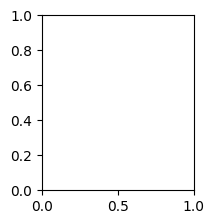

In [ ]:
def plot_gallery(images, titles, h, w, n_rows=3, n_cols=5):
    plt.figure(figsize=(1.8 * n_cols, 2.4 * n_rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)  # 修正：n_rows 和 i+1（整数索引）
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(prediction, true_label, target_names):
    pred_name = target_names[prediction].split(' ')[-1]
    true_name = target_names[true_label].split(' ')[-1]
    return f'predicted: {pred_name}\ntrue:      {true_name}'

# 修正：传入 predictions[i] 和 y_test[i] 作为参数
prediction_titles = [title(predictions[i], y_test[i], target_names) for i in range(len(predictions))]
plot_gallery(X_rare_test, prediction_titles, h, w)
plt.show()